## **Importing**

In [183]:
import numpy as np
import pandas  as pd
import math
import keras
import sklearn.model_selection
import matplotlib.pyplot as plt
from numpy import linalg as LA

##**Reading and preprocessing data**

In [184]:
dataframe = pd.read_csv('spam.csv', encoding= "ISO-8859-1")

dataframe = dataframe.iloc[:,:2]


dataframe.columns = ["Class","Content"]
dataframe["Class_number"] = pd.factorize(dataframe["Class"])[0]

#pretvaranje znakova u integere
def contentToIntegers(dataframeRow):
  return [ord(character) for character in dataframeRow["Content"]]

dataframe["Content_integers"] = dataframe.apply(contentToIntegers, axis=1)

#pronalazak najveceg integera zbog skaliranja
maxInteger = -math.inf
for i in range(len(dataframe["Content_integers"])):
  for j in range(len(dataframe["Content_integers"][i])):
    if dataframe["Content_integers"][i][j] > maxInteger:
      maxInteger = dataframe["Content_integers"][i][j]

#kreiranje training i testing skupa
X = dataframe["Content_integers"].values

for i in range(len(dataframe)):
  X[i] = np.asarray(X[i])

y = dataframe["Class_number"].values
y = y.reshape(len(y), 1)


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

maxLength = 100
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxLength) #poruke moraju biti istih velicina - rezemo ih na duljinu maxLength
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxLength)

X_train = X_train / maxInteger #skaliranje na [0,1]
X_test = X_test / maxInteger

#algoritmi su pisani za obrnute dimenzije
X_test = X_test.T
X_train = X_train.T
y_test = y_test.T
y_train = y_train.T

## **Sigmoid function, error function and intializing parameters**

In [185]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def initialize(n):
  W = np.zeros((n,1))
  b = 0.0

  return W, b


def errorFunction(X, Y, W, b):
  n = X.shape[1]

  a = sigmoid(np.dot(W.T, X) + b)      #a = g(Wx + b)

  E_vector = (-1 / n) * (Y * np.log(a) + (1-Y) * np.log(1-a))
  
  E = 0.0
  for i in range(len(E_vector)):
    E = E + E_vector[i]

  gradW = (1 / n) * np.dot(X, (a-Y).T)

  gradB_vector = (1 / n) * (a-Y)
  gradB = 0.0
  for i in range(len(gradB_vector)):
    gradB = gradB + gradB_vector[i][0]  

  return E, gradW, gradB

## **Gradient descent**

In [186]:
def gradientDescent(X, Y, W, b, numberOfIterations, learningRate):
  errorsForPlot = []

  for i in range(numberOfIterations):
    if i % 100 == 0:
      print('Iteracija: ',i)
    
    E, gradW, gradB = errorFunction(X, Y, W, b)
    
    W = W - learningRate * gradW
    b = b - learningRate * gradB

    errorsForPlot.append(E)

  return W, b, gradW, gradB, errorsForPlot

## **Prediction**

In [187]:
def predictClass(Z, W, b):
  n = Z.shape[1]
  ZClass = np.zeros((1,n))
  W = W.reshape(Z.shape[0], 1)

  a = sigmoid(np.dot(W.T, Z) + b)

  ZClass = np.around(a, decimals=0)

  return ZClass

## **Complete network**

In [188]:
def neuralNetwork(X_train, y_train, X_test, y_test, numberOfIterations, learningRate):
  W, b = initialize(X_train.shape[0])

  W, b, gradW, gradB, errorsForPlot = gradientDescent(X_train, y_train, W, b, numberOfIterations, learningRate) #gradijentni spust numberOfIterations puta

  y_trainClass = predictClass(X_train, W, b)  
  y_testClass = predictClass(X_test, W, b)

  #Provjera tocnosti na testing i training skupu
  print("train accuracy: {} %".format(100 - np.mean(np.abs(y_trainClass - y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(y_testClass - y_test)) * 100))

  return y_trainClass, y_testClass, W, b, errorsForPlot

## **Testing the network**

Prvi pristup - na temelju brojevne reprezentacije poruka
Iteracija:  0
Iteracija:  100
Iteracija:  200
Iteracija:  300
Iteracija:  400
Iteracija:  500
Iteracija:  600
Iteracija:  700
Iteracija:  800
Iteracija:  900
Iteracija:  1000
Iteracija:  1100
Iteracija:  1200
Iteracija:  1300
Iteracija:  1400
Iteracija:  1500
Iteracija:  1600
Iteracija:  1700
Iteracija:  1800
Iteracija:  1900
train accuracy: 90.28205128205128 %
test accuracy: 90.2511961722488 %
Drugi pristup - kljucne rijeci
Iteracija:  0
Iteracija:  100
Iteracija:  200
Iteracija:  300
Iteracija:  400
Iteracija:  500
Iteracija:  600
Iteracija:  700
Iteracija:  800
Iteracija:  900
Iteracija:  1000
Iteracija:  1100
Iteracija:  1200
Iteracija:  1300
Iteracija:  1400
Iteracija:  1500
Iteracija:  1600
Iteracija:  1700
Iteracija:  1800
Iteracija:  1900
train accuracy: 94.20364195947678 %
test accuracy: 92.88702928870293 %


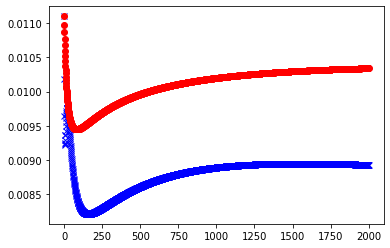

In [189]:
numberOfIterations = 2000
learningRate = 0.1

print("Prvi pristup - na temelju brojevne reprezentacije poruka")
#ucenje na temelju samog sadrzaja poruke pretvorenog u integere
Y_trainClass, Y_testClass, W, b, errorsForPlot = neuralNetwork(X_train, y_train, X_test, y_test, numberOfIterations, learningRate)

n = len(errorsForPlot)
error = []
for i in range(n):
  error.append(LA.norm(errorsForPlot[i]))

x = np.arange(0, n, 1)
plt.plot(x,error, 'bx')

#ucitava se dataset procesiran u programu za kmeans algoritam
#nalaze se najcesce rijeci u porukama te se na temelju njih klasterira spam i ham
X_trainTokenized = np.loadtxt(open("X_trainTokenized.csv", "rb"), delimiter=",")
X_testTokenized = np.loadtxt(open("X_testTokenized.csv", "rb"), delimiter=",")

y_Tokenized = np.loadtxt(open("ShuffledLabels.csv", "rb"), delimiter=",")

#tokeniziran y_train:
y_trainTokenized = y_Tokenized[:3899]
y_testTokenized = y_Tokenized[3899:]

print("Drugi pristup - kljucne rijeci")

Y_trainClass2, Y_testClass2, W2, b2, errorsForPlot2 = neuralNetwork(X_trainTokenized, y_trainTokenized, X_testTokenized, y_testTokenized, numberOfIterations, learningRate)

n = len(errorsForPlot2)
error2 = []
for i in range(n):
  error2.append(LA.norm(errorsForPlot2[i]))

x2 = np.arange(0, n, 1)
plt.plot(x2,error2, 'ro')